In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import logging

from config import CFG_HMN_LOCAL
from kde_classes import Model, KDE

# Logging setup utilities
from debugging import (
    setup_logger,
    setup_console_handler
)

gamma = 3.5

def powerlaw(energy, phi0=1.0*1e-18, gamma=2.0):
    '''Computes a powerlaw with `phi0` normalization and `gamma` index.
    Parameters
    ----------
    energy : numpy ndarray of floats | float
        Energy.
    phi0 : float
        Powerlaw normalization.
    gamma : float
        Powerlaw index.
    Returns
    -------
    pl : numpy ndarray of floats | float
        Powerlaw with `phi0` normalization and `gamma` index.
    '''
    pl = phi0*(energy / 1.e5)**(-gamma)
    return pl

def pl_weighting(mc, phi0=1.0*1e-18, gamma=gamma):
    return mc['orig_OW']*powerlaw(mc['trueE'], phi0=phi0, gamma=gamma)

eval_energy = 1.e3 # 10 TeV
eval_logE = np.log10(eval_energy)

eval_sigma = 0.5 # deg
eval_logS = np.log10(np.deg2rad(eval_sigma))

eval_psi = np.linspace(1.e-4, 7.0, 200) # deg
eval_logpsi = np.log10(np.deg2rad(eval_psi))

arbitrary_constant = 4./10.

setup_logger('KDE', logging.DEBUG)
setup_console_handler('KDE', logging.DEBUG)

Welcome to JupyROOT 6.14/04


/home/hans/.local/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.15.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
# generate 2D KDE
model = Model('sig_E_HMN', mc=None, weighting=pl_weighting)
kde_2d = KDE(model)
binned_kde_2d = kde_2d.generate_binned_kd([0.065, 0.19])

{'astro': 'astro', 'trueE': 'trueE', 'log_psi': 'log_psi', 'conv': 'conv', 'log_e': 'log_e', 'ow': 'orig_OW', 'sigmaOK': 'sigmaOK', 'trueDec': 'trueDec', 'sigma': 'log_sigma_pull_corrected'}


In [ ]:
# generate 3D KDE (hybrid method)
model = Model('psi_sig_E_HMN', mc=None, weighting=pl_weighting)
kde_3d = KDE(model)
hybrid_kde_3d = kde_3d.generate_hybrid_kd(binned_kde_2d, arbitrary_constant = 0.4)

{'astro': 'astro', 'trueE': 'trueE', 'log_psi': 'log_psi', 'conv': 'conv', 'log_e': 'log_e', 'ow': 'orig_OW', 'sigmaOK': 'sigmaOK', 'trueDec': 'trueDec', 'sigma': 'log_sigma_pull_corrected'}


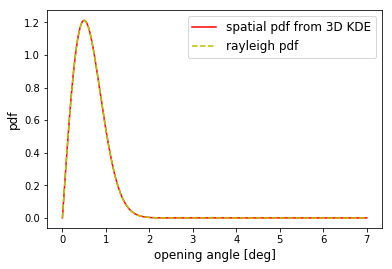

In [11]:
# visualize rayleigh pdf
# and compare to KDE - should be identical by construction

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    coord = (tp, eval_logS, eval_logE)
    kde_vals3d.append(kde_3d.eval_point(hybrid_kde_3d, coord))

    coord = (eval_logS, eval_logE)
    kde_vals2d.append(kde_2d.eval_point(binned_kde_2d, coord))

# visualize spatial term
spatial_pdf = (np.asarray(kde_vals3d) / np.asarray(kde_vals2d) - arbitrary_constant * np.log(10)) *  1./np.power(10., eval_logpsi) * 1./np.log(10)

plt.plot(eval_psi, spatial_pdf * np.pi/180  , "r-", label="spatial pdf from 3D KDE")

## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.legend(fontsize=12)

In [12]:
# use hybrid KDE as seed
#binned_kde_3d_wapprox = kde_3d.generate_binned_kd([0.3, 0.065, 0.19], pdf_approx=hybrid_kde_3d)

/home/hans/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


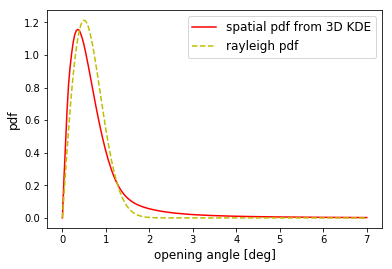

In [15]:
# visualize rayleigh pdf
# and compare to KDE - should be identical by construction

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    coord = (tp, eval_logS, eval_logE)
    kde_vals3d.append(kde_3d.eval_point(binned_kde_3d_wapprox, coord))

    coord = (eval_logS, eval_logE)
    kde_vals2d.append(kde_2d.eval_point(binned_kde_2d, coord))

# visualize spatial term
spatial_pdf_full_approx = (np.asarray(kde_vals3d) / np.asarray(kde_vals2d)) *  1./np.power(10., eval_logpsi) * 1./np.log(10)

plt.plot(eval_psi, spatial_pdf_full_approx * np.pi/180  , "r-", label="spatial pdf from 3D KDE")

## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.legend(fontsize=12)

In [14]:
# generate 3D binned KDE without approx
binned_kde_3d = kde_3d.generate_binned_kd([ 0.09, 0.11, 0.19])

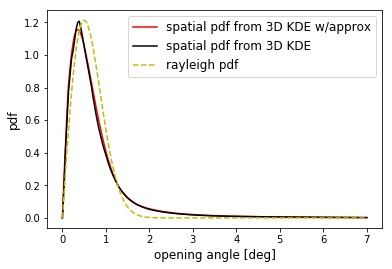

In [16]:
# compare all 3
# evaluate KDEs

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    coord = (tp, eval_logS, eval_logE)
    kde_vals3d.append(kde_3d.eval_point(binned_kde_3d, coord))

    coord = (eval_logS, eval_logE)
    kde_vals2d.append(kde_2d.eval_point(binned_kde_2d, coord))
    
# visualize spatial term
spatial_pdf_full = np.asarray(kde_vals3d) / np.asarray(kde_vals2d) *  1./np.power(10., eval_logpsi) * 1./np.log(10)

plt.plot(eval_psi, spatial_pdf_full_approx * np.pi/180 , "r-", label="spatial pdf from 3D KDE w/approx")
plt.plot(eval_psi, spatial_pdf_full * np.pi/180 , "k-", label="spatial pdf from 3D KDE")
## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.legend(fontsize=12)

In [ ]:
# still need to port code below!
# still need to port code below!
# still need to port code below!
# still need to port code below!
# still need to port code below!
# still need to port code below!
# still need to port code below!

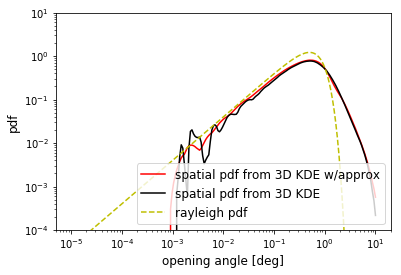

In [15]:
# check near source behavior
eval_psi = np.logspace(-5,1, 200) # deg
eval_logpsi = np.log10(np.deg2rad(eval_psi))

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    d = 3
    v = std.vector(Double)(d)
    v[0] = tp
    v[1] = eval_logS
    v[2] = eval_logE
    kde_vals3d.append(kde_3D_full.density(v) * kde_norm_3D)
    
    d = 2
    v = std.vector(Double)(d)
    v[0] = eval_logS
    v[1] = eval_logE
    kde_vals2d.append(kde_2D.density(v) * kde_norm_2D)
    
spatial_pdf_full = np.asarray(kde_vals3d) / np.asarray(kde_vals2d) *  1./np.power(10., eval_logpsi) * 1./np.log(10)


kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    d = 3
    v = std.vector(Double)(d)
    v[0] = tp
    v[1] = eval_logS
    v[2] = eval_logE
    kde_vals3d.append(kde_3D_full_approx.density(v) * kde_norm_3D)
    
    d = 2
    v = std.vector(Double)(d)
    v[0] = eval_logS
    v[1] = eval_logE
    kde_vals2d.append(kde_2D.density(v) * kde_norm_2D)
    
# visualize spatial term
spatial_pdf_full_approx = np.asarray(kde_vals3d) / np.asarray(kde_vals2d) *  1./np.power(10., eval_logpsi) * 1./np.log(10)

plt.plot(eval_psi, spatial_pdf_full_approx * np.pi/180 , "r-", label="spatial pdf from 3D KDE w/approx")
plt.plot(eval_psi, spatial_pdf_full * np.pi/180 , "k-", label="spatial pdf from 3D KDE")
## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-4, 1.e1])
plt.legend(fontsize=12)

crit pdf value 0.4957943954783596


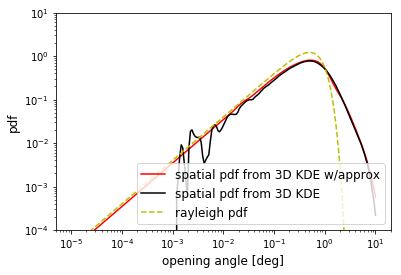

In [17]:
# with near source linear extrapolation
# check near source behavior

# to first order a rayleigh behaves as 
# Psi / sigma ** 2 as psi gets small.

crit_val = np.log10(10 ** (-1.5) * 10.** eval_logS)

# evaluate critical pdf value
d = 3
v = std.vector(Double)(d)
v[0] = crit_val 
v[1] = eval_logS
v[2] = eval_logE
crit_pdf_val = kde_3D_full_approx.density(v) * kde_norm_3D

d = 2
v = std.vector(Double)(d)
v[0] = eval_logS
v[1] = eval_logE
crit_pdf_val = crit_pdf_val / (kde_2D.density(v) * kde_norm_2D) * 1./np.power(10., crit_val) * 1./np.log(10)
print "crit pdf value", np.log10(crit_pdf_val)


eval_psi = np.logspace(-5,1, 200) # deg
eval_logpsi = np.log10(np.deg2rad(eval_psi))

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    d = 3
    v = std.vector(Double)(d)
    v[0] = tp
    v[1] = eval_logS
    v[2] = eval_logE
    kde_vals3d.append(kde_3D_full.density(v) * kde_norm_3D)
    
    d = 2
    v = std.vector(Double)(d)
    v[0] = eval_logS
    v[1] = eval_logE
    kde_vals2d.append(kde_2D.density(v) * kde_norm_2D)
    
spatial_pdf_full = np.asarray(kde_vals3d) / np.asarray(kde_vals2d) *  1./np.power(10., eval_logpsi) * 1./np.log(10)



spatial_pdf_full_approx = [] 

for tp in eval_logpsi: 
    if tp > crit_val:
        d = 3
        v = std.vector(Double)(d)
        v[0] = tp
        v[1] = eval_logS
        v[2] = eval_logE
        p3d = kde_3D_full_approx.density(v) * kde_norm_3D
        
        d = 2
        v = std.vector(Double)(d)
        v[0] = eval_logS
        v[1] = eval_logE
        p2d = kde_2D.density(v) * kde_norm_2D
        
        spatial_pdf_full_approx.append( p3d / p2d * 1./np.power(10., tp) * 1./np.log(10) )
    else:
        # need to extrapolate assuming rayleigh
        s2 = (10**eval_logS)**2
        c0 = crit_pdf_val * s2 / 10**crit_val 
        spatial_pdf_full_approx.append( c0 * 10**tp / s2 )

spatial_pdf_full_approx = np.asarray(spatial_pdf_full_approx)  

# visualize spatial term

plt.plot(eval_psi, spatial_pdf_full_approx * np.pi/180 , "r-", label="spatial pdf from 3D KDE w/approx")
plt.plot(eval_psi, spatial_pdf_full * np.pi/180 , "k-", label="spatial pdf from 3D KDE")
## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-4, 1.e1])
plt.legend(fontsize=12)

crit pdf value 0.4957943954783596


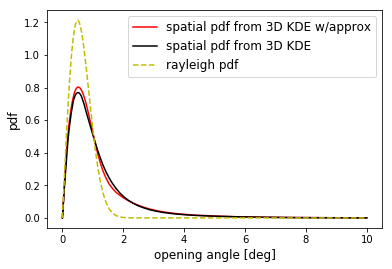

In [21]:
eval_psi = np.linspace(1.e-4,7.0, 200) # deg
eval_logpsi = np.log10(np.deg2rad(eval_psi))

# with near source linear extrapolation
# check near source behavior

# to first order a rayleigh behaves as 
# Psi / sigma ** 2 as psi gets small.

crit_val = np.log10(10 ** (-1.5) * 10.** eval_logS)

# evaluate critical pdf value
d = 3
v = std.vector(Double)(d)
v[0] = crit_val 
v[1] = eval_logS
v[2] = eval_logE
crit_pdf_val = kde_3D_full_approx.density(v) * kde_norm_3D

d = 2
v = std.vector(Double)(d)
v[0] = eval_logS
v[1] = eval_logE
crit_pdf_val = crit_pdf_val / (kde_2D.density(v) * kde_norm_2D) * 1./np.power(10., crit_val) * 1./np.log(10)
print "crit pdf value", np.log10(crit_pdf_val)


eval_psi = np.logspace(-5,1, 200) # deg
eval_logpsi = np.log10(np.deg2rad(eval_psi))

kde_vals3d = []
kde_vals2d = []

for tp in eval_logpsi:
    d = 3
    v = std.vector(Double)(d)
    v[0] = tp
    v[1] = eval_logS
    v[2] = eval_logE
    kde_vals3d.append(kde_3D_full.density(v) * kde_norm_3D)
    
    d = 2
    v = std.vector(Double)(d)
    v[0] = eval_logS
    v[1] = eval_logE
    kde_vals2d.append(kde_2D.density(v) * kde_norm_2D)
    
spatial_pdf_full = np.asarray(kde_vals3d) / np.asarray(kde_vals2d) *  1./np.power(10., eval_logpsi) * 1./np.log(10)



spatial_pdf_full_approx = [] 

for tp in eval_logpsi: 
    if tp > crit_val:
        d = 3
        v = std.vector(Double)(d)
        v[0] = tp
        v[1] = eval_logS
        v[2] = eval_logE
        p3d = kde_3D_full_approx.density(v) * kde_norm_3D
        
        d = 2
        v = std.vector(Double)(d)
        v[0] = eval_logS
        v[1] = eval_logE
        p2d = kde_2D.density(v) * kde_norm_2D
        
        spatial_pdf_full_approx.append( p3d / p2d * 1./np.power(10., tp) * 1./np.log(10) )
    else:
        # need to extrapolate assuming rayleigh
        s2 = (10**eval_logS)**2
        c0 = crit_pdf_val * s2 / 10**crit_val 
        spatial_pdf_full_approx.append( c0 * 10**tp / s2 )

spatial_pdf_full_approx = np.asarray(spatial_pdf_full_approx)  

# visualize spatial term

plt.plot(eval_psi, spatial_pdf_full_approx * np.pi/180 , "r-", label="spatial pdf from 3D KDE w/approx")
plt.plot(eval_psi, spatial_pdf_full * np.pi/180 , "k-", label="spatial pdf from 3D KDE")
## round trip check
y = eval_psi / eval_sigma**2 * np.exp(-0.5 * eval_psi**2 / eval_sigma**2)
plt.plot(eval_psi, y, "y--", label='rayleigh pdf')
plt.xlabel('opening angle [deg]', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.legend(fontsize=12)

In [18]:
# bw generation should be simplified
# need only optimize bw for 2D sigma and logE
# and use that bw in 3D KDE with logpsi
# only CV on logpsi.
